In [1]:

import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial
from tqdm.notebook import tqdm, trange


### **Importing Drive (Dataset-Small Village-Sensefly)**

In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
plt.figure(figsize=(20,10)) 


<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

In [4]:

class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(img)
  plt.show()
  


In [5]:

def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M,len(best_inliers)




In [6]:

def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def ImageBounds(img, H):

    h, w= img.shape[0], img.shape[1]
    p1 = np.dot(H, np.array([0, 0, 1]))
    p2 = np.dot(H, np.array([0, h - 1, 1]))
    p3 = np.dot(H, np.array([w - 1, 0, 1]))
    p4 = np.dot(H, np.array([w - 1, h - 1, 1]))
    x1 = p1[0] / p1[2]
    y1 = p1[1] / p1[2]
    x2 = p2[0] / p2[2]
    y2 = p2[1] / p2[2]
    x3 = p3[0] / p3[2]
    y3 = p3[1] / p3[2]
    x4 = p4[0] / p4[2]
    y4 = p4[1] / p4[2]
    minX = math.ceil(min(x1, x2, x3, x4))
    minY = math.ceil(min(y1, y2, y3, y4))
    maxX = math.ceil(max(x1, x2, x3, x4))
    maxY = math.ceil(max(y1, y2, y3, y4))

    return int(minX), int(minY), int(maxX), int(maxY)
  
  
def Populate_Images(img, accumulator, H, bw):
  


    h, w = img.shape[0], img.shape[1]
    minX, minY, maxX, maxY = ImageBounds(img, H)

    for i in range(minX, maxX + 1):
        for j in range(minY, maxY + 1):
            p = np.dot(np.linalg.inv(H), np.array([i, j, 1]))

            x = p[0]
            y = p[1]
            z = p[2]

            _x = int(x / z)
            _y = int(y / z)

            if _x < 0 or _x >= w - 1 or _y < 0 or _y >= h - 1:
                continue

            if img[_y, _x, 0] == 0 and img[_y, _x, 1] == 0 and img[_y, _x, 2] == 0:
                continue

            wt = 1.0

            if _x >= minX and _x < minX + bw:
                wt = float(_x - minX) /bw
            if _x <= maxX and _x > maxX -bw:
                wt = float(maxX - _x) /bw

            accumulator[j, i, 3] += wt

            for c in range(3):
                accumulator[j, i, c] += img[_y, _x, c] *wt


  

In [7]:

def Image_Stitch(Imagesall, blendWidth, accWidth, accHeight, translation):
    channels=3
    #width=720

    acc = np.zeros((accHeight, accWidth, channels + 1))
    M = np.identity(3)
    for count, i in enumerate(Imagesall):
        M = i.position
        img = i.img
        M_trans = translation.dot(M)
        Populate_Images(img, acc, M_trans, blendWidth)
    
    height, width = acc.shape[0], acc.shape[1]

    img = np.zeros((height, width, 3))
    for i in range(height):
        for j in range(width):
            weights = acc[i, j, 3]
            if weights > 0:
                for c in range(3):
                    img[i, j, c] = int(acc[i, j, c] / weights)
                    

    Imagefull = np.uint8(img)
    M = np.identity(3)
    for count, i in enumerate(Imagesall):
        if count != 0 and count != (len(Imagesall) - 1):
            continue

        M = i.position

        M_trans = translation.dot(M)

        p = np.array([0.5 * width, 0, 1])
        p = M_trans.dot(p)

        
        if count == 0:
            x_init, y_init = p[:2] / p[2]
        
        if count == (len(Imagesall) - 1):
            x_final, y_final = p[:2] / p[2]
    
    
    A = np.identity(3)
    croppedImage = cv2.warpPerspective(
        Imagefull, A, (accWidth, accHeight), flags=cv2.INTER_LINEAR
    )
    displayplot(croppedImage, 'Final Stitched Image')



In [8]:
#!pip uninstall opencv-python
#!pip install opencv-contrib-python===4.4.0.44
#!pip install opencv-python==4.4.0.44
#!pip install opencv-contrib-python==4.4.0.44

In [9]:
import cv2
print(cv2.__version__)

4.1.2


## **Reading images and Extracting the SuperPoint (Self-Supervised Interest Point Detection and Description) Features**

In [10]:
!pip install ipython-autotime

%load_ext autotime


time: 155 µs (started: 2021-06-02 13:13:17 +00:00)


In [11]:
files_all=[]
for file in os.listdir("/content/drive/My Drive/Small_Village"):
    if file.endswith(".JPG"):
      files_all.append(file)



#files_all = os.listdir('/content/drive/My Drive/tech_park/')
files_all.sort()
folder_path = '/content/drive/My Drive/Small_Village/'

centre_file = folder_path + files_all[7]
left_files_path_rev = []
right_files_path = []

for file in files_all[4:8]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[7:10]:
  right_files_path.append(folder_path + file)


time: 833 ms (started: 2021-06-02 13:13:17 +00:00)


In [12]:
'''
files_all=[]
for file in os.listdir("/content/drive/My Drive/tech_park"):
    if file.endswith(".JPG"):
      files_all.append(file)



#files_all = os.listdir('/content/drive/My Drive/tech_park/')
files_all.sort()
folder_path = '/content/drive/My Drive/tech_park/'

centre_file = folder_path + files_all[4+3]
left_files_path_rev = []
right_files_path = []

for file in files_all[:6]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[5:11]:
  right_files_path.append(folder_path + file)
'''

'\nfiles_all=[]\nfor file in os.listdir("/content/drive/My Drive/tech_park"):\n    if file.endswith(".JPG"):\n      files_all.append(file)\n\n\n\n#files_all = os.listdir(\'/content/drive/My Drive/tech_park/\')\nfiles_all.sort()\nfolder_path = \'/content/drive/My Drive/tech_park/\'\n\ncentre_file = folder_path + files_all[4+3]\nleft_files_path_rev = []\nright_files_path = []\n\nfor file in files_all[:6]:\n  left_files_path_rev.append(folder_path + file)\n\nleft_files_path = left_files_path_rev[::-1]\n\nfor file in files_all[5:11]:\n  right_files_path.append(folder_path + file)\n'

time: 4.57 ms (started: 2021-06-02 13:13:18 +00:00)


In [13]:
'''
files_all = os.listdir('/content/drive/My Drive/small_villages_2/')
files_all.sort()
folder_path = '/content/drive/My Drive/small_villages_2/'

centre_file = folder_path + files_all[7]
left_files_path_rev = []
right_files_path = []

for file in files_all[:8]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[7:15]:
  right_files_path.append(folder_path + file)
'''

"\nfiles_all = os.listdir('/content/drive/My Drive/small_villages_2/')\nfiles_all.sort()\nfolder_path = '/content/drive/My Drive/small_villages_2/'\n\ncentre_file = folder_path + files_all[7]\nleft_files_path_rev = []\nright_files_path = []\n\nfor file in files_all[:8]:\n  left_files_path_rev.append(folder_path + file)\n\nleft_files_path = left_files_path_rev[::-1]\n\nfor file in files_all[7:15]:\n  right_files_path.append(folder_path + file)\n"

time: 4.5 ms (started: 2021-06-02 13:13:18 +00:00)


In [14]:
print(left_files_path)

['/content/drive/My Drive/Small_Village/IMG_1027.JPG', '/content/drive/My Drive/Small_Village/IMG_1026.JPG', '/content/drive/My Drive/Small_Village/IMG_1025.JPG', '/content/drive/My Drive/Small_Village/IMG_1024.JPG']
time: 1.11 ms (started: 2021-06-02 13:13:18 +00:00)


In [15]:
print(right_files_path)

['/content/drive/My Drive/Small_Village/IMG_1027.JPG', '/content/drive/My Drive/Small_Village/IMG_1028.JPG', '/content/drive/My Drive/Small_Village/IMG_1029.JPG']
time: 908 µs (started: 2021-06-02 13:13:18 +00:00)


In [46]:
images_left_bgr = []
images_right_bgr = []

for file in tqdm(left_files_path):
  left_img_sat= cv2.imread(file)
  left_img = cv2.resize(left_img_sat,None,fx=0.5, fy=0.5, interpolation = cv2.INTER_AREA)

  images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
  right_img_sat= cv2.imread(file)
  right_img = cv2.resize(right_img_sat,None,fx=0.5,fy=0.5, interpolation = cv2.INTER_AREA)

  images_right_bgr.append(right_img)




time: 1.82 s (started: 2021-06-02 13:27:37 +00:00)


In [16]:
images_left = []
images_right = []

for file in tqdm(left_files_path):
  left_img_sat= cv2.imread(file,0)
  #left_img = cv2.resize(left_img_sat,None,fx=0.75, fy=0.75, interpolation = cv2.INTER_CUBIC)
  #left_img_gray = cv2.cvtColor(left_img,cv2.COLOR_BGR2GRAY)
  interp = cv2.INTER_AREA
  grayim = left_img_sat
  grayim = cv2.resize(left_img_sat,None,fx=0.5, fy=0.5, interpolation=interp)
  grayim = (grayim.astype('float32') / 255.)

  images_left.append(grayim)


for file in tqdm(right_files_path):
  right_img_sat= cv2.imread(file,0)
  #right_img = cv2.resize(right_img_sat,None,fx=0.75,fy=0.75, interpolation = cv2.INTER_CUBIC)
  #right_img_gray = cv2.cvtColor(right_img,cv2.COLOR_BGR2GRAY)
  interp = cv2.INTER_AREA
  grayim = right_img_sat
  grayim = cv2.resize(right_img_sat,None,fx=0.5, fy=0.5, interpolation=interp)
  grayim = (grayim.astype('float32') / 255.)

  images_right.append(grayim)




time: 9.66 s (started: 2021-06-02 13:13:18 +00:00)


In [17]:
!git clone https://github.com/aritra0593/Reinforced-Feature-Points.git

Cloning into 'Reinforced-Feature-Points'...
remote: Enumerating objects: 19996, done.
remote: Counting objects: 100% (5365/5365), done.
remote: Compressing objects: 100% (3579/3579), done.
^C
time: 6.75 s (started: 2021-06-02 13:13:42 +00:00)


In [19]:
%cd Reinforced-Feature-Points

/content/Reinforced-Feature-Points
time: 3.31 ms (started: 2021-06-02 11:52:43 +00:00)


In [20]:
from network import SuperPointFrontend

time: 2.71 s (started: 2021-06-02 11:52:46 +00:00)


In [28]:
%cd ..

/content
time: 2.75 ms (started: 2021-06-02 12:00:35 +00:00)


In [18]:
!git clone https://github.com/magicleap/SuperPointPretrainedNetwork.git

Cloning into 'SuperPointPretrainedNetwork'...
remote: Enumerating objects: 81, done.
remote: Total 81 (delta 0), reused 0 (delta 0), pack-reused 81
Unpacking objects: 100% (81/81), done.
time: 4.54 s (started: 2021-06-02 13:13:57 +00:00)


In [ ]:
!ls

drive  sample_data  SuperPointPretrainedNetwork
time: 113 ms (started: 2021-06-02 08:49:17 +00:00)


In [ ]:
#!SuperPointPretrainedNetwork/demo_superpoint.py drive/MyDrive/Small_Village_Subset/ --weights_path 'SuperPointPretrainedNetwork/superpoint_v1.pth'

In [19]:
weights_path = 'SuperPointPretrainedNetwork/superpoint_v1.pth'

cuda = 'True'

time: 1.21 ms (started: 2021-06-02 13:14:05 +00:00)


## **Extracting the Keypoints and Descriptors**

In [20]:
def to_kpts(pts, size=1):
  return [cv2.KeyPoint(pt[0], pt[1], size) for pt in pts]

time: 2.82 ms (started: 2021-06-02 13:14:10 +00:00)


In [21]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


class SuperPointNet(nn.Module):
    def __init__(self):
        super(SuperPointNet, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
        # Shared Encoder.
        self.conv1a = nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
        self.conv1b = nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
        self.conv2a = nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
        self.conv2b = nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
        self.conv3a = nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
        self.conv3b = nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
        self.conv4a = nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
        self.conv4b = nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)
        # Detector Head.
        self.convPa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convPb = nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)
        # Descriptor Head.
        self.convDa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convDb = nn.Conv2d(c5, d1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):

        # Shared Encoder.
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        # Detector Head.
        cPa = self.relu(self.convPa(x))
        semi = self.convPb(cPa)
        # Descriptor Head.
        cDa = self.relu(self.convDa(x))
        desc = self.convDb(cDa)
        dn = torch.norm(desc, p=2, dim=1) # Compute the norm.
        desc = desc.div(torch.unsqueeze(dn, 1)) # Divide by norm to normalize.
        return semi, desc


class SuperPointFrontend(object):
    def __init__(self, weights_path, nms_dist, conf_thresh, nn_thresh,cuda=True):
        self.name = 'SuperPoint'
        self.cuda = cuda
        self.nms_dist = nms_dist
        self.conf_thresh = conf_thresh
        self.nn_thresh = nn_thresh # L2 descriptor distance for good match.
        self.cell = 8 # Size of each output cell. Keep this fixed.
        self.border_remove = 4 # Remove points this close to the border.

        # Load the network in inference mode.
        self.net = SuperPointNet()
        if cuda:
          # Train on GPU, deploy on GPU.
            self.net.load_state_dict(torch.load(weights_path))
            self.net = self.net.cuda()
        else:
          # Train on GPU, deploy on CPU.
            self.net.load_state_dict(torch.load(weights_path, map_location=lambda storage, loc: storage))
        self.net.eval()

    def nms_fast(self, in_corners, H, W, dist_thresh):

        grid = np.zeros((H, W)).astype(int) # Track NMS data.
        inds = np.zeros((H, W)).astype(int) # Store indices of points.
        # Sort by confidence and round to nearest int.
        inds1 = np.argsort(-in_corners[2,:])
        corners = in_corners[:,inds1]
        rcorners = corners[:2,:].round().astype(int) # Rounded corners.
        # Check for edge case of 0 or 1 corners.
        if rcorners.shape[1] == 0:
            return np.zeros((3,0)).astype(int), np.zeros(0).astype(int)
        if rcorners.shape[1] == 1:
            out = np.vstack((rcorners, in_corners[2])).reshape(3,1)
            return out, np.zeros((1)).astype(int)
        # Initialize the grid.
        for i, rc in enumerate(rcorners.T):
            grid[rcorners[1,i], rcorners[0,i]] = 1
            inds[rcorners[1,i], rcorners[0,i]] = i
        # Pad the border of the grid, so that we can NMS points near the border.
        pad = dist_thresh
        grid = np.pad(grid, ((pad,pad), (pad,pad)), mode='constant')
        # Iterate through points, highest to lowest conf, suppress neighborhood.
        count = 0
        for i, rc in enumerate(rcorners.T):
          # Account for top and left padding.
            pt = (rc[0]+pad, rc[1]+pad)
            if grid[pt[1], pt[0]] == 1: # If not yet suppressed.
                grid[pt[1]-pad:pt[1]+pad+1, pt[0]-pad:pt[0]+pad+1] = 0
                grid[pt[1], pt[0]] = -1
                count += 1
        # Get all surviving -1's and return sorted array of remaining corners.
        keepy, keepx = np.where(grid==-1)
        keepy, keepx = keepy - pad, keepx - pad
        inds_keep = inds[keepy, keepx]
        out = corners[:, inds_keep]
        values = out[-1, :]
        inds2 = np.argsort(-values)
        out = out[:, inds2]
        out_inds = inds1[inds_keep[inds2]]
        return out, out_inds

    def run(self, img):
        assert img.ndim == 2 #Image must be grayscale.
        assert img.dtype == np.float32 #Image must be float32.
        H, W = img.shape[0], img.shape[1]
        inp = img.copy()
        inp = (inp.reshape(1, H, W))
        inp = torch.from_numpy(inp)
        inp = torch.autograd.Variable(inp).view(1, 1, H, W)
        if self.cuda:
            inp = inp.cuda()
        # Forward pass of network.
        outs = self.net.forward(inp)
        semi, coarse_desc = outs[0], outs[1]
        # Convert pytorch -> numpy.
        semi = semi.data.cpu().numpy().squeeze()
        
        # --- Process points.
        dense = np.exp(semi) # Softmax.
        dense = dense / (np.sum(dense, axis=0)+.00001) # Should sum to 1.
        nodust = dense[:-1, :, :]
        # Reshape to get full resolution heatmap.
        Hc = int(H / self.cell)
        Wc = int(W / self.cell)
        nodust = np.transpose(nodust, [1, 2, 0])
        heatmap = np.reshape(nodust, [Hc, Wc, self.cell, self.cell])
        heatmap = np.transpose(heatmap, [0, 2, 1, 3])
        heatmap = np.reshape(heatmap, [Hc*self.cell, Wc*self.cell]) 
        prob_map = heatmap/np.sum(np.sum(heatmap))
        
        return heatmap, coarse_desc


    def key_pt_sampling(self, img, heat_map, coarse_desc, sampled):
        
        H, W = img.shape[0], img.shape[1]

        xs, ys = np.where(heat_map >= self.conf_thresh) # Confidence threshold.
        if len(xs) == 0:
            return np.zeros((3, 0)), None, None
        print("number of pts selected :", len(xs))
        
        
        pts = np.zeros((3, len(xs))) # Populate point data sized 3xN.
        pts[0, :] = ys
        pts[1, :] = xs
        pts[2, :] = heat_map[xs, ys]
        pts, _ = self.nms_fast(pts, H, W, dist_thresh=self.nms_dist) # Apply NMS.
        inds = np.argsort(pts[2,:])
        pts = pts[:,inds[::-1]] # Sort by confidence.
        bord = self.border_remove
        toremoveW = np.logical_or(pts[0, :] < bord, pts[0, :] >= (W-bord))
        toremoveH = np.logical_or(pts[1, :] < bord, pts[1, :] >= (H-bord))
        toremove = np.logical_or(toremoveW, toremoveH)
        pts = pts[:, ~toremove]
        pts = pts[:,0:sampled] #we take 2000 keypoints with highest probability from heatmap for our benchmark
        
        # --- Process descriptor.
        D = coarse_desc.shape[1]
        if pts.shape[1] == 0:
            desc = np.zeros((D, 0))
        else:
          # Interpolate into descriptor map using 2D point locations.
            samp_pts = torch.from_numpy(pts[:2, :].copy())
            samp_pts[0, :] = (samp_pts[0, :] / (float(W)/2.)) - 1.
            samp_pts[1, :] = (samp_pts[1, :] / (float(H)/2.)) - 1.
            samp_pts = samp_pts.transpose(0, 1).contiguous()
            samp_pts = samp_pts.view(1, 1, -1, 2)
            samp_pts = samp_pts.float()
            if self.cuda:
                samp_pts = samp_pts.cuda()            
            desc = nn.functional.grid_sample(coarse_desc, samp_pts)
            desc = desc.data.cpu().numpy().reshape(D, -1)
            desc /= np.linalg.norm(desc, axis=0)[np.newaxis, :]

            
        return pts, desc

time: 2.55 s (started: 2021-06-02 13:14:13 +00:00)


## **Loading and Initialing the SuperPoint Pretrained Network**

In [22]:
print('Loading pre-trained network.')
# This class runs the SuperPoint network and processes its outputs.
fe = SuperPointFrontend(weights_path=weights_path,nms_dist = 4,conf_thresh = 0.015,nn_thresh=0.7,
                        cuda=cuda)
print('Successfully loaded pre-trained network.')

==> Loading pre-trained network.
==> Successfully loaded pre-trained network.
time: 6.97 s (started: 2021-06-02 13:14:19 +00:00)


## **Example case of extracting keypoints and descriptors b/w 2 images**

In [41]:
heatmap1, coarse_desc1 = fe.run(images_left[0])
pts_1, desc_1 = fe.key_pt_sampling(images_left[0], heatmap1, coarse_desc1, 2000) #Getting keypoints and descriptors for 1st image

number of pts selected : 36214
time: 290 ms (started: 2021-06-02 12:05:34 +00:00)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3829: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


In [42]:
heatmap2, coarse_desc2 = fe.run(images_left[1])
pts_2, desc_2 = fe.key_pt_sampling(images_left[1], heatmap2, coarse_desc2, 2000) #Getting keypoints and descriptors for 1st image

number of pts selected : 54604
time: 355 ms (started: 2021-06-02 12:06:10 +00:00)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3829: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


In [44]:
desc1 = desc_1.T
desc2 = desc_2.T

bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(desc1,desc2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)


print("Found %d total matches." % len(matches))

Found 1042 total matches.
time: 202 ms (started: 2021-06-02 12:06:57 +00:00)


In [100]:
def match_descriptors(kp1, desc1, kp2, desc2):
    # Match the keypoints with the warped_keypoints with nearest neighbor search
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(desc1, desc2)
    print(len(matches))
    matches_idx = np.array([m.queryIdx for m in matches])
    m_kp1 = [kp1[idx] for idx in matches_idx]
    matches_idx = np.array([m.trainIdx for m in matches])
    m_kp2 = [kp2[idx] for idx in matches_idx]

    return m_kp1, m_kp2, matches
def compute_homography_fast(matched_kp1, matched_kp2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1[:, [1, 0]],
                                    matched_pts2[:, [1, 0]],
                                    cv2.RANSAC)
    inliers = inliers.flatten()
    return H, inliers

time: 9.65 ms (started: 2021-06-02 12:48:39 +00:00)


In [47]:
print(left_files_path)

['/content/drive/My Drive/Small_Village/IMG_1029.JPG', '/content/drive/My Drive/Small_Village/IMG_1028.JPG', '/content/drive/My Drive/Small_Village/IMG_1027.JPG', '/content/drive/My Drive/Small_Village/IMG_1026.JPG', '/content/drive/My Drive/Small_Village/IMG_1025.JPG', '/content/drive/My Drive/Small_Village/IMG_1024.JPG']
time: 1.25 ms (started: 2021-06-02 12:14:50 +00:00)


In [95]:
m_kp1, m_kp2, matches = match_descriptors(pts_2.T, desc2, pts_1.T, desc1)

1042
time: 183 ms (started: 2021-06-02 12:44:38 +00:00)


In [64]:
print(m_kp1[0])

[1.10200000e+03 1.14500000e+03 7.42762864e-01]
time: 1.63 ms (started: 2021-06-02 12:24:23 +00:00)


In [88]:
for i in range(50):
  image = cv2.circle(images_left[0], (int(m_kp1[i][0]),int(m_kp1[i][1])), radius=0, color=(0, 255, 0), thickness=30)

time: 2.38 ms (started: 2021-06-02 12:40:36 +00:00)


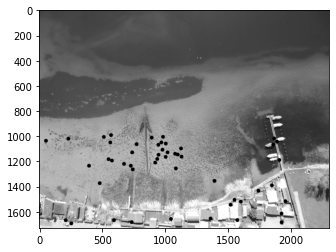

time: 660 ms (started: 2021-06-02 12:40:38 +00:00)


In [89]:
plt.imshow(image,cmap='gray')

In [90]:
for i in range(50):
  image = cv2.circle(images_left[1], (int(m_kp2[i][0]),int(m_kp2[i][1])), radius=0, color=(0, 255, 0), thickness=30)

time: 2.94 ms (started: 2021-06-02 12:40:49 +00:00)


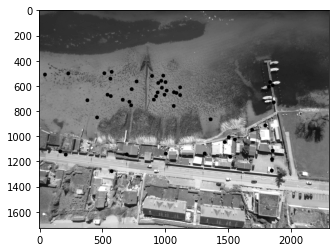

time: 732 ms (started: 2021-06-02 12:40:50 +00:00)


In [91]:
plt.imshow(image,cmap='gray')

In [ ]:
print(to_kpts(m_kp1))

In [76]:
print(len(to_kpts(m_kp2)))

1042
time: 3.15 ms (started: 2021-06-02 12:33:40 +00:00)


In [77]:
print(len(to_kpts(m_kp1)))

1042
time: 2.58 ms (started: 2021-06-02 12:33:53 +00:00)


In [78]:
print(len(matches))

1042
time: 929 µs (started: 2021-06-02 12:34:03 +00:00)


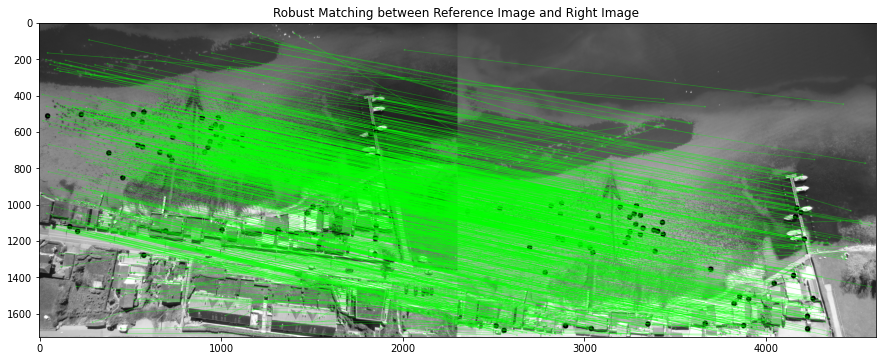

time: 920 ms (started: 2021-06-02 12:46:11 +00:00)


In [98]:
dispimg1=cv2.drawMatches(np.uint8(images_left[1]*255),to_kpts(pts_2.T), np.uint8(images_left[0]*255), to_kpts(pts_1.T), matches, None,(0,255,0),flags=2)
displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')

## **Now Extracting Keypoints and Descriptors from all images and storing them**

In [23]:

keypoints_all_left = []
descriptors_all_left = []
points_all_left=[]

keypoints_all_right = []
descriptors_all_right = []
points_all_right=[]

for lfpth in tqdm(images_left):
  heatmap1, coarse_desc1 = fe.run(lfpth)
  pts_1, desc_1 = fe.key_pt_sampling(lfpth, heatmap1, coarse_desc1, 2000) #Getting keypoints and descriptors for 1st image

  keypoints_all_left.append(to_kpts(pts_1.T))
  descriptors_all_left.append(desc_1.T)
  points_all_left.append(pts_1.T)


for rfpth in tqdm(images_right):
  heatmap1, coarse_desc1 = fe.run(rfpth)
  pts_1, desc_1 = fe.key_pt_sampling(rfpth, heatmap1, coarse_desc1, 2000) #Getting keypoints and descriptors for 1st image

  keypoints_all_right.append(to_kpts(pts_1.T))
  descriptors_all_right.append(desc_1.T)
  points_all_right.append(pts_1.T)

number of pts selected : 65110


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3829: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


number of pts selected : 67328
number of pts selected : 52224
number of pts selected : 32293



number of pts selected : 65110
number of pts selected : 54604
number of pts selected : 36214

time: 2.63 s (started: 2021-06-02 13:14:39 +00:00)


## **Image Matching (Robust) through RANSAC and Homography Matrix computation**

In [ ]:
#!pip install numba  # pip

In [48]:

def get_Hmatrix(imgs,keypts,pts,descripts,disp=True):
  FLANN_INDEX_KDTREE = 2
  index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
  search_params = dict(checks=50)
  flann = cv2.FlannBasedMatcher(index_params, search_params)
  ransac_thresh = 2
  #bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)



  lff1 = np.float32(descripts[0])
  lff = np.float32(descripts[1])

  #matches_lf1_lf = bf.match(lff1, lff)

  matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)

  print(len(matches_lf1_lf))

  #matches_4 = matches_lf1_lf

  
  
  matches_4 = []
  ratio = 0.5
  # loop over the raw matches
  for m in matches_lf1_lf:
    # ensure the distance is within a certain ratio of each
    # other (i.e. Lowe’s ratio test)
    if len(m) == 2 and m[0].distance < m[1].distance * ratio:
        #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])

  print("Number of matches",len(matches_4))

  if len(matches_4)<20:
    matches_4 = []
    ratio = 0.93
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches",len(matches_4))
    ransac_thresh = 9
  
  

  #matches_4=[]
  #for m in matches_lf1_lf:
  #  matches_4.append(m[0])


  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  #Hn = H
  #Robustly estimate Homography 1 using RANSAC
  Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=ransac_thresh)

  global inlier_matchset   

  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')

  return Hn/Hn[2,2]






time: 59.9 ms (started: 2021-06-02 13:28:40 +00:00)


In [ ]:
print(len(images_left))

6
time: 854 µs (started: 2021-06-01 12:30:18 +00:00)


In [ ]:
print(len(images_right))

6
time: 843 µs (started: 2021-06-01 12:30:27 +00:00)


2000
Number of matches 251
Number of best inliers 78


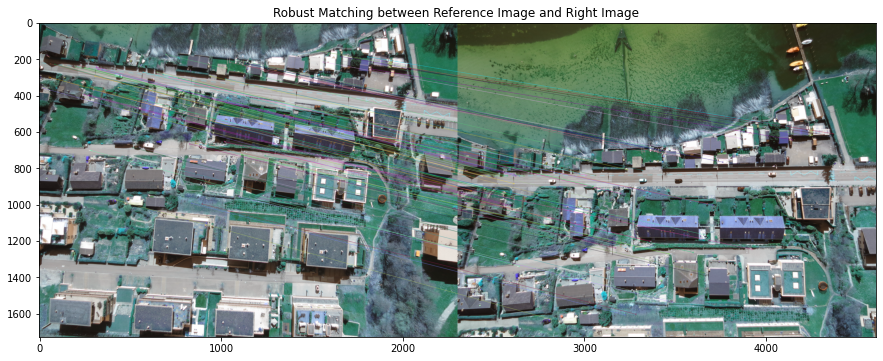

2000
Number of matches 239
Number of best inliers 44


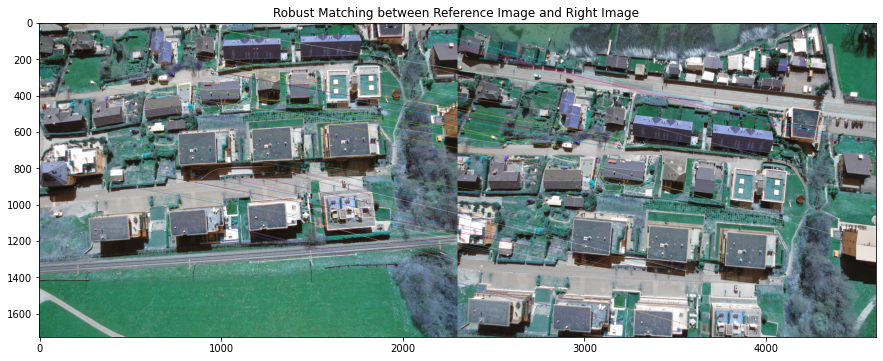

2000
Number of matches 227
Number of best inliers 48


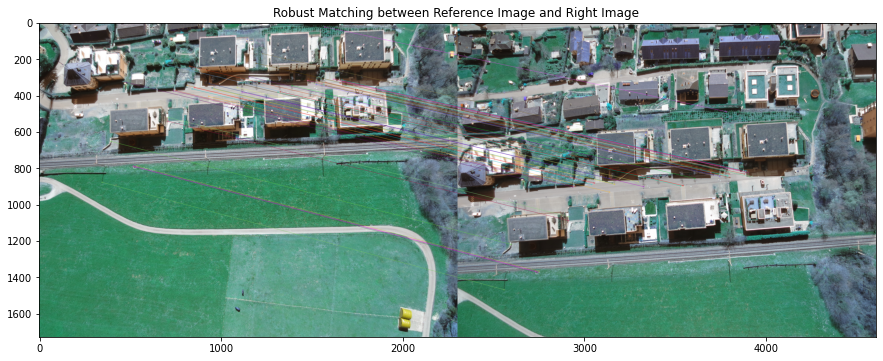

2000
Number of matches 417
Number of best inliers 255


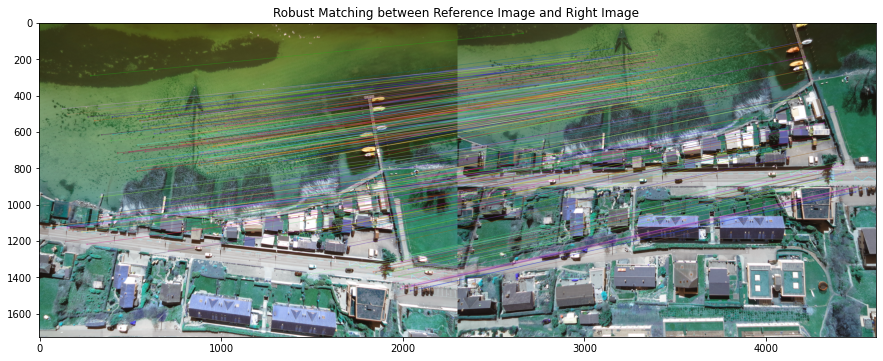

2000
Number of matches 514
Number of best inliers 415


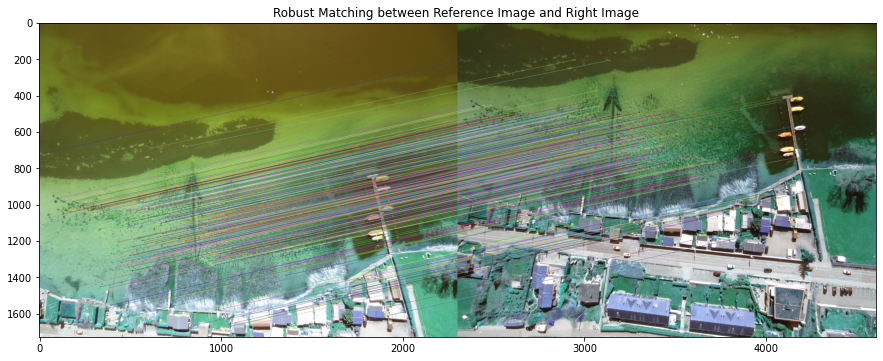

time: 35.7 s (started: 2021-06-02 13:28:46 +00:00)


In [49]:
H_left = []
H_right = []
poor_match_index_left = []
poor_match_index_right = []

for j in tqdm(range(len(images_left))):
  #print(j)
  if j==len(images_left)-1:
    break

  H_a = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left[j:j+2][::-1],points_all_left[j:j+2][::-1],descriptors_all_left[j:j+2][::-1])

  #if len2<34:
  #  poor_match_index_left.append(j+1)
  #  continue

  H_left.append(H_a)

for j in tqdm(range(len(images_right))):
  if j==len(images_right)-1:
    break

  H_a = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right[j:j+2][::-1],points_all_right[j:j+2][::-1],descriptors_all_right[j:j+2][::-1])

  #if len2<34:
  #  poor_match_index_right.append(j+1)
  #  continue


  H_right.append(H_a)


In [26]:
print(len(H_left),len(H_right))

3 2
time: 1.24 ms (started: 2021-06-02 13:15:21 +00:00)


## **Perspective Transformation b/w consecutive pairs through the computed Homography Matrices**

In [27]:
def warpnImages(images_left, images_right,H_left,H_right,poor_match_index_left,poor_match_index_right):
    #img1-centre,img2-left,img3-right

    h, w = images_left[0].shape[:2]

    pts_left = []
    pts_right = []

    pts_centre = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)

    for j in range(len(H_left)):
      pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
      pts_left.append(pts)

    for j in range(len(H_right)):
      pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
      pts_right.append(pts)

    pts_left_transformed=[]
    pts_right_transformed=[]

    for j,pts in enumerate(pts_left):
      if j==0:
        H_trans = H_left[j]
      else:
        H_trans = H_trans@H_left[j]
      pts_ = cv2.perspectiveTransform(pts, H_trans)
      pts_left_transformed.append(pts_)

    for j,pts in enumerate(pts_right):
      if j==0:
        H_trans = H_right[j]
      else:
        H_trans = H_trans@H_right[j]
      pts_ = cv2.perspectiveTransform(pts, H_trans)
      pts_right_transformed.append(pts_)


    print('Step1:Done')


    #pts = np.concatenate((pts1, pts2_), axis=0)

    pts_concat = np.concatenate((pts_centre,np.concatenate(np.array(pts_left_transformed),axis=0),np.concatenate(np.array(pts_right_transformed),axis=0)), axis=0)

    [xmin, ymin] = np.int32(pts_concat.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts_concat.max(axis=0).ravel() + 0.5)
    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])  # translate

    print('Step2:Done')

    warp_imgs_left = []
    warp_imgs_right = []


    for j,H in enumerate(H_left):
      #print(j)
      #if j ==2:
        #result = cv2.warpPerspective(images_left[j+2], H_trans, (xmax-xmin, ymax-ymin))
        #warp_imgs_left.append(result)
      #  continue
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H


      result = cv2.warpPerspective(images_left[j+1], H_trans, (xmax-xmin, ymax-ymin))
      #plt.imshow(result)
      #plt.show()


      if j==0:
        result[t[1]:h+t[1], t[0]:w+t[0]] = images_left[0]
      
      warp_imgs_left.append(result)
    


    for j,H in enumerate(H_right):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H

      if j in poor_match_index_right:
        result = cv2.warpPerspective(images_right[j+2], H_trans, (xmax-xmin, ymax-ymin))
        warp_imgs_right.append(result)
        continue

      result = cv2.warpPerspective(images_right[j+1], H_trans, (xmax-xmin, ymax-ymin))
      
      warp_imgs_right.append(result)

    print('Step3:Done')

    #Union

    warp_images_all = warp_imgs_left + warp_imgs_right

    warp_img_init = warp_images_all[0]

    #warp_final_all=[]

    for j,warp_img in enumerate(warp_images_all):
      if j==len(warp_images_all)-1:
        break
      #if j==1:
      #  continue
      
      warp_final = np.maximum(warp_img_init,warp_images_all[j+1])
      warp_img_init = warp_final
      #print(j)
      
      #plt.imshow(warp_final)
      #plt.show()

      #warp_final_all.append(warp_final)

    print('Step4:Done')


    return warp_final








  

time: 166 ms (started: 2021-06-02 13:15:31 +00:00)


In [52]:
combined_warp_n = warpnImages(images_left_bgr, images_right_bgr,H_left,H_right,poor_match_index_left,poor_match_index_right)

Step1:Done
Step2:Done
Step3:Done
Step4:Done
time: 492 ms (started: 2021-06-02 13:30:17 +00:00)


## **Final Mosaiced Image (with 6 images)**

Text(0.5, 1.0, '6-Images Mosaic - BGR')

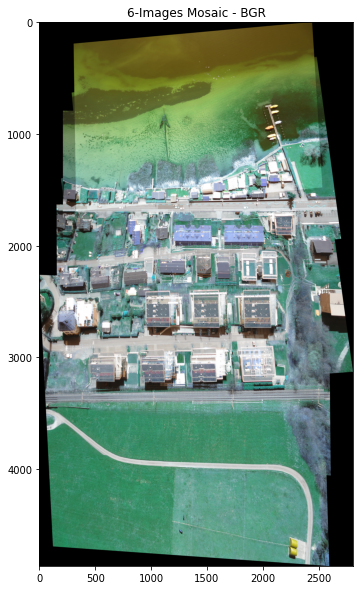

time: 1.9 s (started: 2021-06-02 13:30:21 +00:00)


In [53]:
plt.figure(figsize = (20,10))


plt.imshow(combined_warp_n)
plt.title('6-Images Mosaic - BGR')

Text(0.5, 1.0, '6-Images Mosaic - RGB')

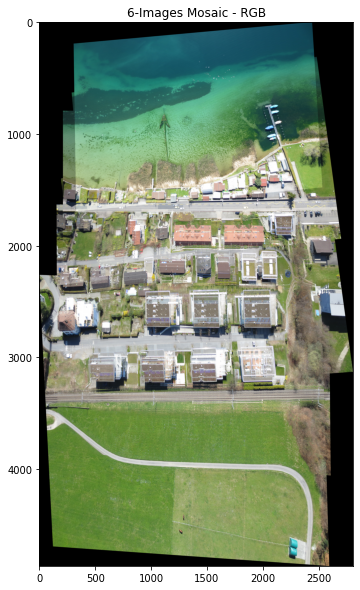

time: 1.91 s (started: 2021-06-02 13:31:03 +00:00)


In [54]:
plt.figure(figsize = (20,10))


plt.imshow(cv2.cvtColor(combined_warp_n,cv2.COLOR_BGR2RGB))
plt.title('6-Images Mosaic - RGB')

## **Observation**

A bit blurry like R2D2 features, could be improved by post-processing and/or maybe just using the overlapping regions while feature-matching.

## **To Do Tasks:**

*   Introduce Geo-Referencing into the stitching pipleine
*   Create a graph-method to pre-select images with good matches because of possibility of poor-matches during linear search. (Auto-Filling). It helps cases wherein if there exist poor matches b/w image-pairs-not to skip the image-entirely but check if it has a better matching with another image.







## **References**

https://github.com/rpautrat/SuperPoint

https://arxiv.org/pdf/1712.07629.pdf

https://github.com/magicleap/SuperPointPretrainedNetwork/blob/master/demo_superpoint.py

